In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def calculate_median(data_list, start_index, end_index):
    return np.median([data['stop_time'] - data['start_time'] for data in data_list[start_index:end_index]])

In [3]:
def extract_median_runtime(df):
    data_list = df[df['data'].notna()]['data']
    keys = data_list.index

    avgs = []
    BATCH_SIZE = 10

    for i in range(0, len(data_list), BATCH_SIZE):
        avg = calculate_median(data_list, i, i + BATCH_SIZE)
        config = keys[i].split(";")
        avgs.append((config[0], config[1], avg))

    df_data = pd.DataFrame(avgs, columns=['cores', 'input', 'exec_time'])
    return df_data

In [4]:
def extract_data(df):
    extracted_patterns = df.index.str.extract(r'(\d+);(\d+);(\d+)', expand=True)
    extracted_patterns.columns = ['cores', 'input', 'repetition']
    df[extracted_patterns.columns] = extracted_patterns[extracted_patterns.columns].values

    df['cores'] = df['cores'].astype(int)
    df['input'] = df['input'].astype(int)

    return df

In [18]:
def merge_real_estimated(df, df_real):
    df_aux = extract_data(df)
    algorithms = df_aux['algorithm'].unique()
    merged_df_final = pd.DataFrame()

    for algorithm in algorithms:
        df_aux_filtered = df_aux[df_aux['algorithm'] == algorithm]
        
        df_aux_grouped = df_aux_filtered.groupby(['cores', 'input', 'algorithm'])['exec_time'].mean().reset_index()
        df_aux_grouped = df_aux_grouped.sort_values(by=['cores', 'input'], ascending=[False, True])

        df_real_aux = df_real[df_real['algorithm'] == algorithm]
        df_real_aux = extract_median_runtime(df_real_aux)
        df_real_aux['cores'] = df_real_aux['cores'].astype(int)
        df_real_aux['input'] = df_real_aux['input'].astype(int)

        merged_df = pd.merge(df_real_aux, df_aux_grouped, on=['cores', 'input'], suffixes=('_real', '_random'))
        merged_df['exec_time_diff'] = merged_df['exec_time_real'] - merged_df['exec_time_random']
        
        merged_df_final = pd.concat([merged_df_final, merged_df])

    return merged_df_final

In [12]:
dirs = os.listdir('./runs/')
df_model = pd.DataFrame()
df_real = pd.DataFrame()
df_model_random = pd .DataFrame()
df_model_single_last = pd.DataFrame()

for dir in dirs:
    files = os.listdir(f'./runs/{dir}')
    model_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'model_linear_output' in f]
    real_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'real_output' in f]
    random_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'model_random_output' in f]
    single_last_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'model_single_last_output' in f]
    
    df_model_aux = pd.read_json(model_path[0])
    df_real_aux = pd.read_json(real_path[0])
    df_random_aux = pd.read_json(random_path[0])

    try:
        df_single_aux = pd.read_json(single_last_path[0])
    except:
        pass

    df_model_aux['algorithm'] = dir
    df_real_aux['algorithm'] = dir
    df_random_aux['algorithm'] = dir
    df_single_aux['algorithm'] = dir

    df_model_aux = df_model_aux[df_model_aux['data'].notna()][['data', 'algorithm']]
    df_real_aux = df_real_aux[df_real_aux['data'].notna()][['data', 'algorithm']]
    df_random_aux = df_random_aux[df_random_aux['data'].notna()][['data', 'algorithm']]
    df_single_aux = df_single_aux[df_single_aux['data'].notna()][['data', 'algorithm']]

    df_model = pd.concat([df_model, df_model_aux])
    df_real = pd.concat([df_real, df_real_aux])
    df_model_random = pd.concat([df_model_random, df_random_aux])
    df_model_single_last = pd.concat([df_model_single_last, df_single_aux])

df_model['exec_time'] = df_model['data'].apply(lambda x: x['stop_time'] - x['start_time'])
df_real['exec_time'] = df_real['data'].apply(lambda x: x['stop_time'] - x['start_time'])
df_model_random['exec_time'] = df_model_random['data'].apply(lambda x: x['stop_time'] - x['start_time'])
df_model_single_last['exec_time'] = df_model_single_last['data'].apply(lambda x: x['stop_time'] - x['start_time'])

In [28]:
merged_random_model = merge_real_estimated(df_model_random, df_real)
random_raytrace = merged_random_model[merged_random_model['algorithm'] == 'raytrace']
pivot_random_raytrace = random_raytrace.pivot(index='cores', columns='input', values='exec_time_diff')

merged_liner_model = merge_real_estimated(df_model_single_last, df_real)
linear_raytrace = merged_liner_model[merged_liner_model['algorithm'] == 'raytrace']
pivot_linear_raytrace = linear_raytrace.pivot(index='cores', columns='input', values='exec_time_diff')

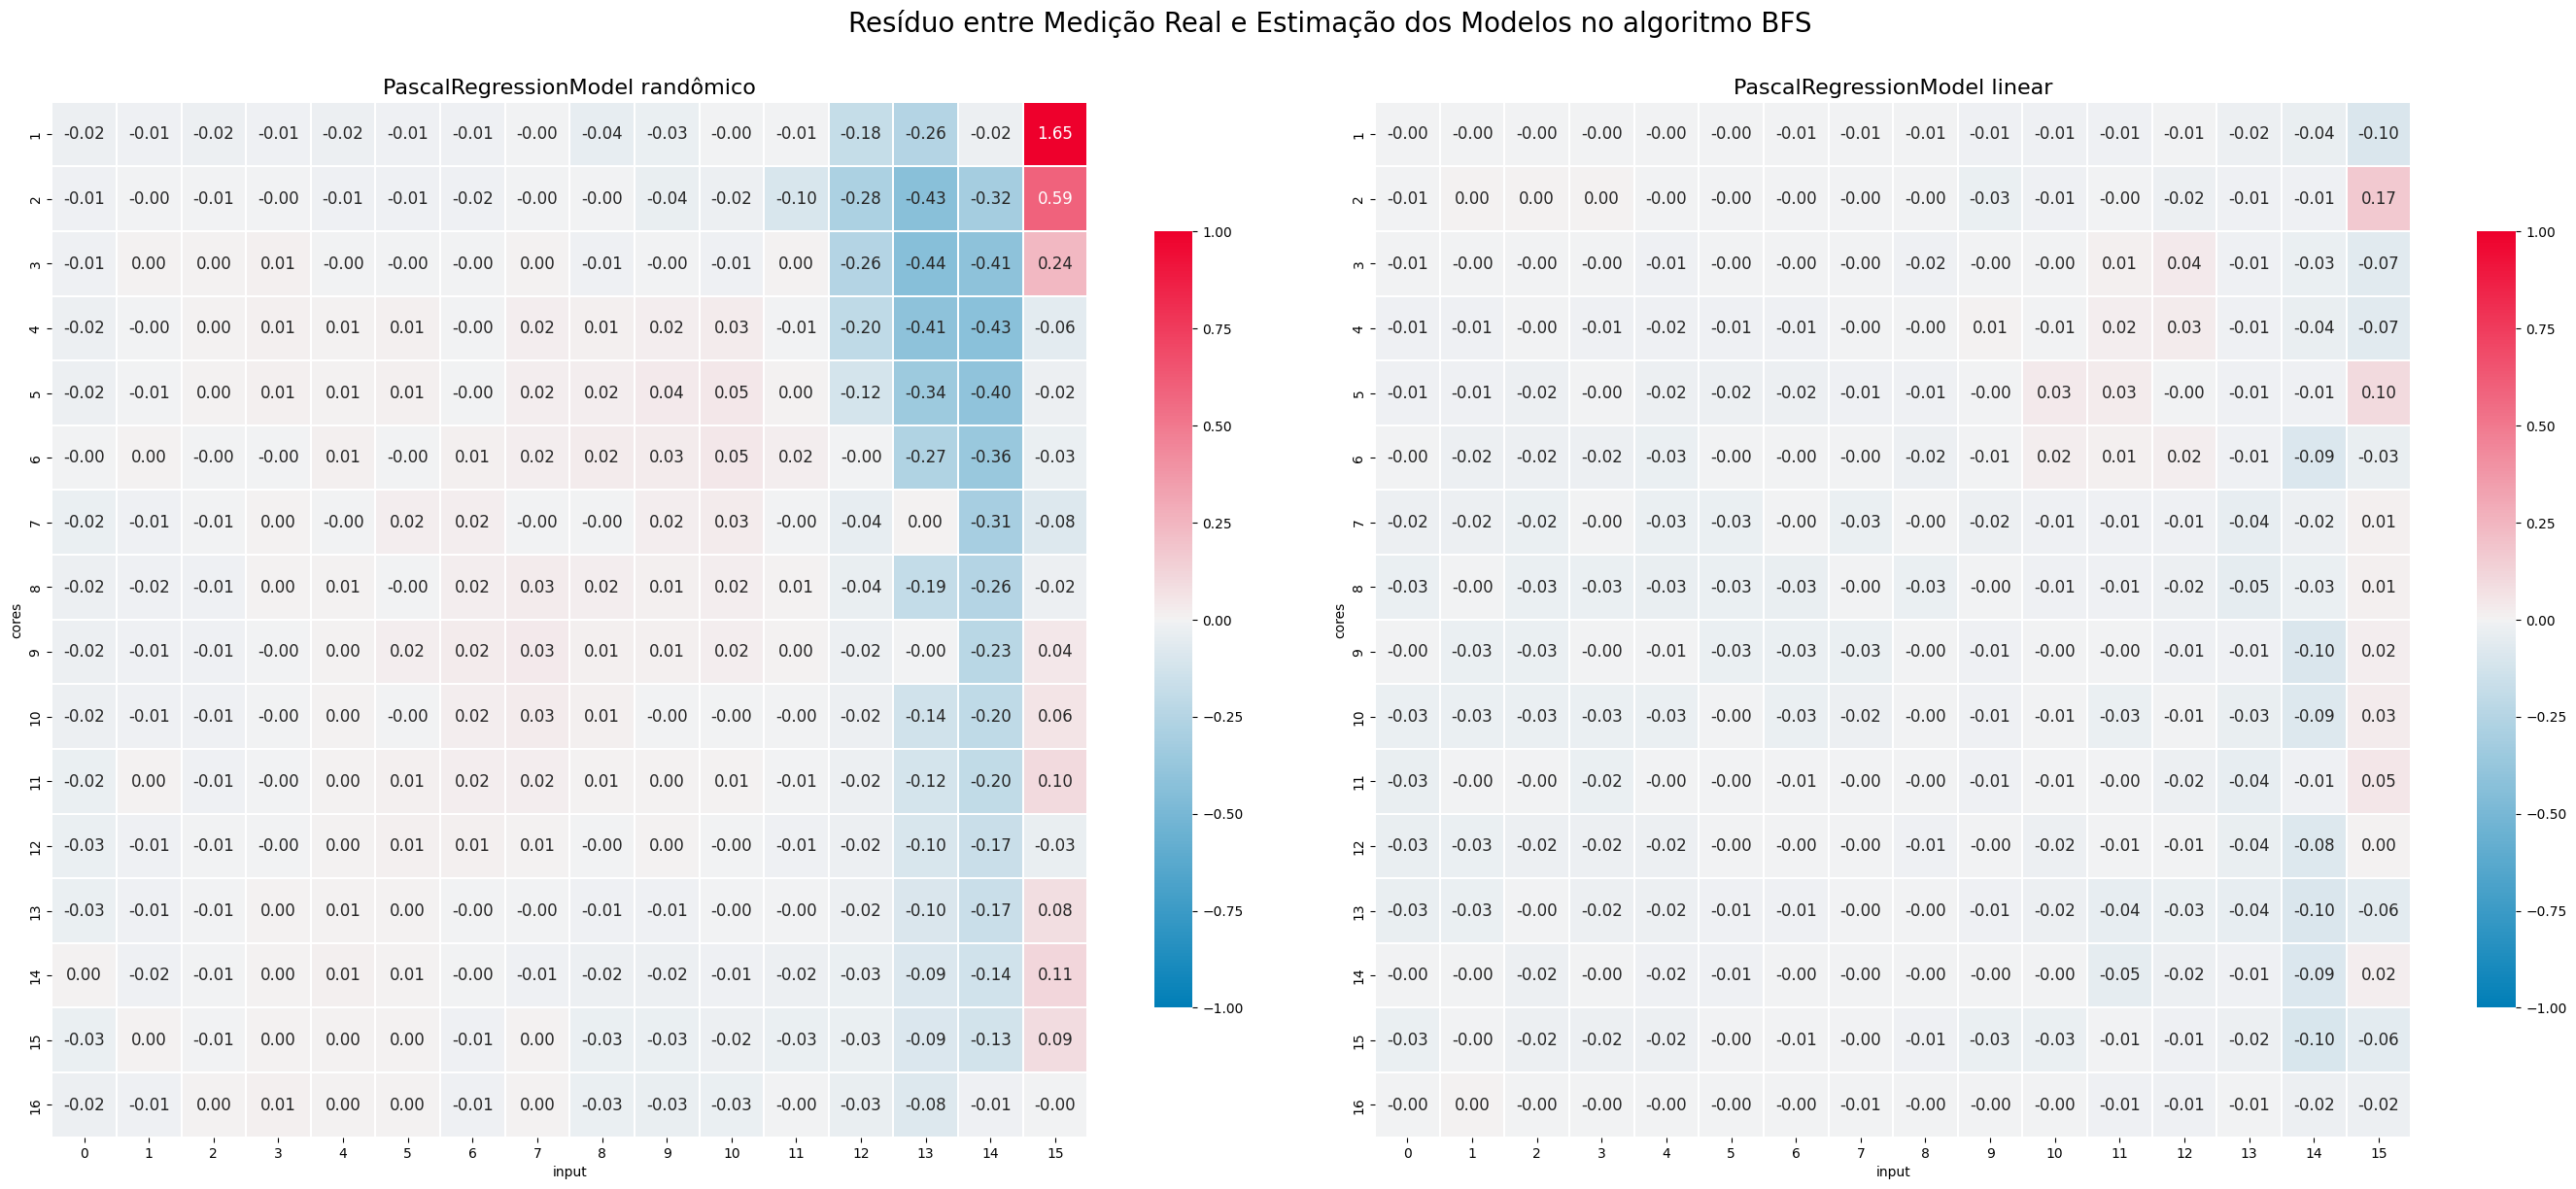

In [56]:
cmap = sns.diverging_palette(
    h_neg=240,
    h_pos=10,
    s=100,
    as_cmap=True,
)

fig, axes = plt.subplots(1, 2, figsize=(28, 12))

sns.heatmap(
    pivot_random_raytrace,
    cmap=cmap,
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.01,
    annot=True,
    fmt='.2f',
    annot_kws={"size": 12},
    cbar_kws={"shrink": 0.75},
    xticklabels=True,
    yticklabels=True,
    ax=axes[0]
)

axes[0].set_title('PascalRegressionModel randômico', fontsize=16)

sns.heatmap(
    pivot_linear_raytrace,
    cmap=cmap,
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.01,
    annot=True,
    fmt='.2f',
    annot_kws={"size": 12},
    cbar_kws={"shrink": 0.75},
    xticklabels=True,
    yticklabels=True,
    ax=axes[1]
)

axes[1].set_title('PascalRegressionModel linear', fontsize=16)

plt.suptitle('Resíduo entre Medição Real e Estimação dos Modelos no algoritmo BFS', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
df_model['data'] = df_model['data'].apply(lambda x: x if x['start_time'] != 0 else None)
df_model = df_model.dropna()

df_model_random['data'] = df_model_random['data'].apply(lambda x: x if x['start_time'] != 0 else None)
df_model_random = df_model_random.dropna()

df_model_single_last['data'] = df_model_single_last['data'].apply(lambda x: x if x['start_time'] != 0 else None)
df_model_single_last = df_model_single_last.dropna()

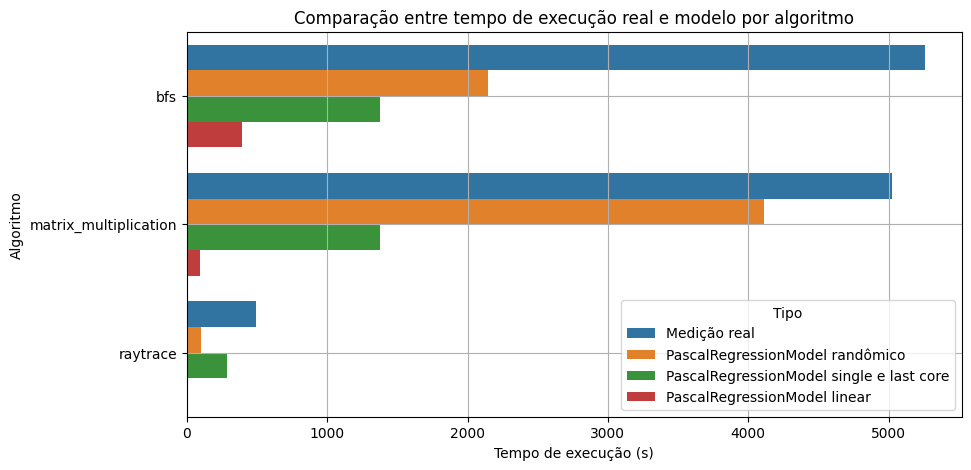

In [9]:
algorithms = df_real['algorithm'].unique()
data = []
for algo in algorithms:
    data.append({'Algoritmo': algo, 'Tipo': 'Medição real', 'Tempo': df_real[df_real['algorithm'] == algo]['exec_time'].sum()})
    data.append({'Algoritmo': algo, 'Tipo': 'PascalRegressionModel randômico', 'Tempo': df_model_random[df_model_random['algorithm'] == algo]['exec_time'].sum()})
    data.append({'Algoritmo': algo, 'Tipo': 'PascalRegressionModel single e last core', 'Tempo': df_model_single_last[df_model_single_last['algorithm'] == algo]['exec_time'].sum()})
    data.append({'Algoritmo': algo, 'Tipo': 'PascalRegressionModel linear', 'Tempo': df_model[df_model['algorithm'] == algo]['exec_time'].sum()})

df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, y='Algoritmo', x='Tempo', hue='Tipo', orient='h')

plt.ylabel('Algoritmo')
plt.xlabel('Tempo de execução (s)')
plt.title('Comparação entre tempo de execução real e modelo por algoritmo')
plt.legend(title='Tipo', loc='lower right')
plt.grid()
plt.show()